In [4]:
!pip install torch nibabel torchinfo 'monai[all]' torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 21.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 19.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 60.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 24.3 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 55.4 MB/s eta 0:00:00:00

In [7]:
from monai.networks.nets import UNet,UNETR
from monai.networks.layers import Norm
import torchinfo
from monai.losses import SSIMLoss

import zipfile
import random
import os

import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchmetrics.functional import structural_similarity_index_measure
from monai.metrics import DiceMetric
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchinfo
import torch.nn as nn
from typing import Tuple, Union
from monai.networks.blocks import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock
from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.nets import ViT

In [53]:
def split_data(source_dir, test_ratio=0.3, max_volumes=700):
    # Get a list of all volume files in the source directory
    volumes = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Limit to the first 400 volumes
    volumes = volumes[:max_volumes]

    # Shuffle volumes randomly
    random.shuffle(volumes)

    # Calculate the split index
    split_index = int(len(volumes) * (1 - test_ratio))

    # Split volumes into train and test sets
    train_volumes = volumes[:split_index]
    test_volumes = volumes[split_index:]

    return train_volumes, test_volumes

# Usage example:
source_dir = "/kaggle/input/openbhb/val_quasiraw"
test_ratio = 0.1  # Adjust this to change the test/train split

train_volumes, test_volumes = split_data(source_dir, test_ratio, max_volumes=700)


print("Training set volumes:", len(train_volumes))
print("Testing set volumes:", len(test_volumes))


Training set volumes: 630
Testing set volumes: 70


In [54]:
import os
import numpy as np
import torch

class BrainMRIDataset(Dataset):
    def __init__(self, base_path, volume_list, target_size=(88, 128, 128), slice_depth=16, transform=None):
        self.base_path = base_path
        self.volume_list = volume_list
        self.target_size = target_size
        self.slice_depth = slice_depth
        self.transform = transform

    def __len__(self):
        return len(self.volume_list)

    def crop(self, volume, start_y=20, end_y=160, start_x=20, end_x=196, start_z=50, end_z=130):
        cropped_volume = volume[start_z:end_z, start_y:end_y, start_x:end_x]
        return cropped_volume

    def get_slices(self, mri_volume):
        if len(mri_volume.shape) != 3:
            mri_volume = mri_volume.squeeze()

        patches = []
        num_slices = mri_volume.shape[0] // self.slice_depth

        for i in range(num_slices):
            start = i * self.slice_depth
            end = start + self.slice_depth
            patch = mri_volume[start:end, :, :]
            patches.append(patch)

        remainder = mri_volume.shape[0] % self.slice_depth
        if remainder > 0:
            patch = mri_volume[-self.slice_depth:, :, :]
            patches.append(patch)

        return patches

    def __getitem__(self, index):
        # Get the filename for the current volume
        volume_file = self.volume_list[index]

        # Construct the file path
        file_path = os.path.join(self.base_path, volume_file)

        # Load the .npy file
        mri_volume = np.load(file_path)  # Shape: (1, 1, 182, 218, 182)

        # Convert to tensor and remove redundant dimensions
        mri_volume = torch.tensor(mri_volume).float().squeeze().squeeze()  # Shape: [182, 218, 182]

        # (C, H, W, D ) - > (C, D, H, W)
        mri_volume = mri_volume.permute(2, 0, 1)

        # Crop to (80, 140, 176)
        mri_crop = self.crop(mri_volume)

        # Resize to target shape (128x128x128)
        mri_resize = F.interpolate(
            mri_crop.unsqueeze(0).unsqueeze(0),
            size=(mri_crop.shape[0], 128, 128),
            mode='trilinear',
            align_corners=False
        ).squeeze()

        # Normalize the volume
        mri_volume = (mri_resize - mri_resize.min()) / (mri_resize.max() - mri_resize.min() + 1e-8)

        # Slice the volume along the depth axis
        mri_slices = self.get_slices(mri_volume)

        # Add channel dimension back to each slice
        mri_slices = [slice.unsqueeze(0) for slice in mri_slices]  # Shape: [1, 128, 128, 8]

        return mri_slices


In [55]:
class SliceDatasetFromList(Dataset):
    def __init__(self, patch_list):
        self.patch_list = [patch for sublist in patch_list for patch in sublist]

    def __len__(self):
        return len(self.patch_list)

    def __getitem__(self, index):
        patch = self.patch_list[index]
        patch_tensor = torch.tensor(patch).float()

        return patch_tensor, patch_tensor



In [56]:
dataset_test = BrainMRIDataset(base_path='/kaggle/input/openbhb/val_quasiraw', volume_list=test_volumes)

Slices_test = SliceDatasetFromList(dataset_test)

test_loader = DataLoader(Slices_test, batch_size=8)


> # UNET

In [99]:
class DownsamplingResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(DownsamplingResidualBlock3D, self).__init__()

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Skip connection
        self.skip_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.skip_bn = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        identity = self.skip_bn(self.skip_conv(x))

        out = self.leaky_relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = self.leaky_relu(out)

        return out

class UpsamplingResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(UpsamplingResidualBlock3D, self).__init__()

        self.conv_transpose1 = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Skip connection
        self.skip_conv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=1, stride=stride, output_padding=1)
        self.skip_bn = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        identity = self.skip_bn(self.skip_conv(x))

        out = self.leaky_relu(self.bn1(self.conv_transpose1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = self.leaky_relu(out)

        return out

class UNet3DWith3DLatent(nn.Module):
    def __init__(self):
        super(UNet3DWith3DLatent, self).__init__()

        # Encoder part
        self.initial_conv = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm3d(32)
        )

        self.encoder = nn.Sequential(
            DownsamplingResidualBlock3D(32, 32),
            DownsamplingResidualBlock3D(32, 64),
            DownsamplingResidualBlock3D(64, 128),
            DownsamplingResidualBlock3D(128, 256)
        )

        # Latent space (remains 3D)
        # No flattening or linear layers, we directly pass the output to the decoder

        # Decoder part
        self.decoder = nn.Sequential(
            UpsamplingResidualBlock3D(256, 256),
            UpsamplingResidualBlock3D(256, 128),
            UpsamplingResidualBlock3D(128, 64),
            UpsamplingResidualBlock3D(64, 32)
        )

        self.final_conv = nn.Conv3d(32, 1, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        # Encoder
        x = self.initial_conv(x)
        x = self.encoder(x)

        latent = x

        # Decoder
        x = self.decoder(latent)

        # Final conv
        x = self.final_conv(x)

        return x

In [100]:

model = UNet3DWith3DLatent()

# batch_size=2, channels=1, depth=64, height=64, width=64 (adjust as per your input dimensions)
torchinfo.summary(model, input_size=(8, 1, 16,  128,  128))


Layer (type:depth-idx)                        Output Shape              Param #
UNet3DWith3DLatent                            [8, 1, 16, 128, 128]      --
├─Sequential: 1-1                             [8, 32, 16, 128, 128]     --
│    └─Conv3d: 2-1                            [8, 32, 16, 128, 128]     4,032
│    └─LeakyReLU: 2-2                         [8, 32, 16, 128, 128]     --
│    └─BatchNorm3d: 2-3                       [8, 32, 16, 128, 128]     64
├─Sequential: 1-2                             [8, 256, 1, 8, 8]         --
│    └─DownsamplingResidualBlock3D: 2-4       [8, 32, 8, 64, 64]        --
│    │    └─Conv3d: 3-1                       [8, 32, 8, 64, 64]        1,056
│    │    └─BatchNorm3d: 3-2                  [8, 32, 8, 64, 64]        64
│    │    └─Conv3d: 3-3                       [8, 32, 8, 64, 64]        27,680
│    │    └─BatchNorm3d: 3-4                  [8, 32, 8, 64, 64]        64
│    │    └─LeakyReLU: 3-5                    [8, 32, 8, 64, 64]        --
│    │    

In [5]:
import torch
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import SSIMLoss
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
import numpy as np

# Set up device  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model architecture (same for all checkpoints)
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    dropout=0.4
).to(device)

# Define checkpoint paths
checkpoint_paths = [
#     "/kaggle/input/unetmodel/3d_MonaiUNET_slices_MSE.pth",
#     "/kaggle/input/unetmodel/3d_MonaiUNET_slices_SSIM.pth",
#     "/kaggle/input/unetmodel/3d_MonaiUNET_slices_dense_SSIM_MSE.pth"
    "/kaggle/input/unetmodel/3d_slices_MSE_Perceptual.pth",
    "/kaggle/input/unetmodel/checkpoint_MSE_mutiScale.pth"
]

def crop(mri_volume, crop_size=(160, 130, 170)):
    d, h, w = mri_volume.shape
    new_d, new_h, new_w = crop_size
    start_d = (d - new_d) // 2
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    return mri_volume[:, start_h:start_h+new_h, start_w:start_w+new_w]

def resize_volume(mri_volume):
    mri_tensor = torch.tensor(mri_volume, dtype=torch.float32)
    mri_resized = F.interpolate(
        mri_tensor.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        size=(mri_tensor.shape[0], 128, 128),  # Only resize height and width
        mode='trilinear',
        align_corners=False
    )
    return mri_resized

def get_slices(mri_volume):
    slices = []
    for i in range(8):
        start = i * 16
        end = start + 16
        slice_chunk = mri_volume[:, :, start:end, :, :]
        slices.append(slice_chunk)
    return slices

def dice_score(true, predicted, threshold=0.5):
    true = true.cpu().numpy().flatten()
    predicted = (predicted.cpu().numpy() > threshold).astype(int).flatten()
    intersection = (true * predicted).sum()
    return (2. * intersection) / (true.sum() + predicted.sum())

# IoU calculation function
def iou_score(true, predicted):
    intersection = (true * predicted).sum()
    union = true.sum() + predicted.sum() - intersection
    return (intersection / (union + 1e-6)).item()  # Avoid division by zero

> # Attention UNET

In [15]:
import torch
import torch.nn as nn

class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock3D, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super(AttentionUNet3D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()

        # Encoder (downsampling) 
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Decoder (upsampling)
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))
            self.attention_blocks.append(AttentionBlock3D(F_g=feature, F_l=feature, F_int=feature // 2))

        self.bottleneck = self._block(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool3d(kernel_size=2, stride=2)(x)

        x = self.bottleneck(x)

        # Decoder path
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)
            skip = skip_connections[i // 2]

            # Apply attention block
            skip = self.attention_blocks[i // 2](x, skip)

            # Concatenate skip connections
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i + 1](x)

        return self.final_conv(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.3), 
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )


In [16]:
model = AttentionUNet3D(in_channels=1, out_channels=1).to(device)
torchinfo.summary(model, input_size=(2, 1, 16,  128,  128))

Layer (type:depth-idx)                   Output Shape              Param #
AttentionUNet3D                          [2, 1, 16, 128, 128]      --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [2, 32, 16, 128, 128]     --
│    │    └─Conv3d: 3-1                  [2, 32, 16, 128, 128]     864
│    │    └─BatchNorm3d: 3-2             [2, 32, 16, 128, 128]     64
│    │    └─ReLU: 3-3                    [2, 32, 16, 128, 128]     --
│    │    └─Dropout3d: 3-4               [2, 32, 16, 128, 128]     --
│    │    └─Conv3d: 3-5                  [2, 32, 16, 128, 128]     27,648
│    │    └─BatchNorm3d: 3-6             [2, 32, 16, 128, 128]     64
│    │    └─ReLU: 3-7                    [2, 32, 16, 128, 128]     --
│    └─Sequential: 2-2                   [2, 64, 8, 64, 64]        --
│    │    └─Conv3d: 3-8                  [2, 64, 8, 64, 64]        55,296
│    │    └─BatchNorm3d: 3-9             [2, 64, 8, 64, 64]        128
│    

In [20]:
import torch
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.networks.nets import AttentionUnet
from monai.networks.layers import Norm
from monai.losses import SSIMLoss
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
import numpy as np

# Set up device  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize the model architecture (same for all checkpoints)
model = AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    kernel_size=3
).to(device)

model = AttentionUNet3D(in_channels=1, out_channels=1).to(device)

# Define checkpoint paths
checkpoint_paths = [
#     '/kaggle/input/attunet/3d_AttUnet_slices_spatial_SSIM_MSE.pth',
    '/kaggle/input/attunet/attUnet_MSE.pth'
]

def crop(mri_volume, crop_size=(160, 130, 170)):
    d, h, w = mri_volume.shape
    new_d, new_h, new_w = crop_size
    start_d = (d - new_d) // 2
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    return mri_volume[:, start_h:start_h+new_h, start_w:start_w+new_w]

def resize_volume(mri_volume):
    mri_tensor = torch.tensor(mri_volume, dtype=torch.float32)
    mri_resized = F.interpolate(
        mri_tensor.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        size=(mri_tensor.shape[0], 128, 128),  # Only resize height and width
        mode='trilinear',
        align_corners=False
    )
    return mri_resized

def get_slices(mri_volume):
    slices = []
    for i in range(8):
        start = i * 16
        end = start + 16
        slice_chunk = mri_volume[:, :, start:end, :, :]
        slices.append(slice_chunk)
    return slices

def dice_score(true, predicted, threshold=0.5):
    true = true.cpu().numpy().flatten()
    predicted = (predicted.cpu().numpy() > threshold).astype(int).flatten()
    intersection = (true * predicted).sum()
    return (2. * intersection) / (true.sum() + predicted.sum())

# IoU calculation function
def iou_score(true, predicted):
    intersection = (true * predicted).sum()
    union = true.sum() + predicted.sum() - intersection
    return (intersection / (union + 1e-6)).item()  # Avoid division by zero

In [27]:
data_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# Loop through each checkpoint
for path in checkpoint_paths:
    # Load model checkpoint
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Loop through all subject subdirectories
    subjects = [os.path.join(data_dir, subj) for subj in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subj))]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    subject_count = 100
    curr_count = 0


    for subject_dir in subjects:
        if curr_count < subject_count:
            t2_path = os.path.join(subject_dir, [f for f in os.listdir(subject_dir) if '_t2.nii' in f][0])
            seg_path = t2_path.replace('_t2.nii', '_seg.nii')

            # Load and normalize volumes
            t2_vol = nib.load(t2_path).get_fdata()
            seg_vol = nib.load(seg_path).get_fdata()
            t2_norm = (t2_vol - np.min(t2_vol)) / (np.max(t2_vol) - np.min(t2_vol))

            # Preprocess volumes
            transpose_vol = np.transpose(t2_norm, (2, 0, 1))  
            cropped_vol = crop(transpose_vol)
            resized_vol = resize_volume(cropped_vol)
            transpose_seg_vol = np.transpose(seg_vol, (2, 0, 1))
            cropped_seg_vol = crop(transpose_seg_vol)
            resized_seg_vol = resize_volume(cropped_seg_vol)

            # Split into slices
            slices_vol = get_slices(resized_vol)
            slices_seg = get_slices(resized_seg_vol)
            
            dice_scores = []
            iou_scores = []

            with torch.no_grad():
                tensor_vol_slice = slices_vol[4].to(device)
                output = model(tensor_vol_slice)
                
                output = (output - output.min()) / (output.max() - output.min())
                
                # Calculate residuals with MSE
                residuals = torch.abs(tensor_vol_slice - output)

                # Apply threshold and calculate Dice score
                threshold = 0.1
                residuals_binary = (residuals > threshold).float()
                tensor_seg_slice = slices_seg[4].to(device)
#                 tensor_seg_slice = (tensor_seg_slice - tensor_seg_slice.min()) / (tensor_seg_slice.max() - tensor_seg_slice.min())
                dice = dice_score(tensor_seg_slice, residuals_binary)

                # Calculate IoU
                iou = iou_score(tensor_seg_slice, residuals_binary)
            
                dice_scores.append(dice)
                iou_scores.append(iou)
            
#             depth = 8  # Slice depth to visualize
            
#             residuals_np = residuals[0, 0, depth, :, :].cpu().numpy()  # Select specific slice
#             residuals_np[residuals_np < 0.1] = 0  # Set values below threshold to zero

#             # Plot the residuals with only anomalies colored
#             fig, ax = plt.subplots(figsize=(6, 6))

#             # Use a colormap only on non-zero values
#             cmap = plt.cm.jet  # Use 'hot', 'jet', or any other desired colormap
#             cmap.set_under('black')  # Set the color for values below threshold to black

#             # Display the residuals image
#             cax = ax.imshow(residuals_np, cmap=cmap, vmin=threshold)
#             ax.set_title('Residuals with Highlighted Anomalies')
# #             plt.colorbar(cax, ax=ax, orientation='vertical', label='Residual Magnitude')
#             plt.show()

        curr_count += 1
        
    dice = np.mean(dice_scores)
    iou = np.mean(iou_scores)
    print(f"Dice Score: {dice:.4f}")
    print(f"iou Score: {iou:.4f}")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Dice Score: 0.0441
iou Score: 0.0225
Dice Score: 0.0446
iou Score: 0.0228


> # UNETR

In [8]:
import torch
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.networks.nets import AttentionUnet
from monai.networks.layers import Norm
from monai.losses import SSIMLoss
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
import numpy as np
import nibabel as nib
from torchmetrics import Dice

In [9]:
class UNETR_Reconstruction(nn.Module):
    """
    Modified UNETR for 3D medical image reconstruction tasks.
    """

    def __init__(
        self,
        in_channels: int,
        img_size: Tuple[int, int, int],
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        pos_embed: str = "perceptron",
        norm_name: Union[Tuple, str] = "instance",
        conv_block: bool = False,
        res_block: bool = True,
        dropout_rate: float = 0.0,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels (e.g., 1 for grayscale MRI).
            img_size: dimension of input image.
            feature_size: dimension of network feature size.
            hidden_size: dimension of hidden layer.
            mlp_dim: dimension of feedforward layer.
            num_heads: number of attention heads.
            pos_embed: position embedding layer type.
            norm_name: feature normalization type and arguments.
            conv_block: bool argument to determine if convolutional block is used.
            res_block: bool argument to determine if residual block is used.
            dropout_rate: fraction of the input units to drop.
        """
        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise AssertionError("dropout_rate should be between 0 and 1.")

        if hidden_size % num_heads != 0:
            raise AssertionError("hidden size should be divisible by num_heads.")

        if pos_embed not in ["conv", "perceptron"]:
            raise KeyError(f"Position embedding layer of type {pos_embed} is not supported.")

        self.num_layers = 12
        self.patch_size = (16, 16, 16)  # UNETR typically uses 16x16x16 patches
        self.feat_size = (
            img_size[0] // self.patch_size[0],
            img_size[1] // self.patch_size[1],
            img_size[2] // self.patch_size[2],
        )
        self.hidden_size = hidden_size
        self.classification = False

        # Vision Transformer (ViT) backbone
        self.vit = ViT(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=self.patch_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_layers=self.num_layers,
            num_heads=num_heads,
            classification=self.classification,
            dropout_rate=dropout_rate,
        )

        # Encoder blocks (extract features at different resolutions)
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )

        # Decoder blocks (upsample and reconstruct the input)
        self.decoder5 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )

        # Output block (reconstruction output, same size as input)
        self.out = nn.Conv3d(feature_size, in_channels, kernel_size=1)  # Reconstruction task requires in_channels output

        # Optional sigmoid activation to keep the output between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def proj_feat(self, x, hidden_size, feat_size):
        x = x.view(x.size(0), feat_size[0], feat_size[1], feat_size[2], hidden_size)
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        return x

    def forward(self, x_in):
        x, hidden_states_out = self.vit(x_in)
        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2, self.hidden_size, self.feat_size))
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3, self.hidden_size, self.feat_size))
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4, self.hidden_size, self.feat_size))
        dec4 = self.proj_feat(x, self.hidden_size, self.feat_size)
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        logits = self.out(out)
        return self.sigmoid(logits)  # Optionally apply sigmoid activation for normalized output


In [9]:
model = UNETR_Reconstruction(in_channels=1, img_size=(16, 128, 128), feature_size=32, norm_name='instance').to(device)
torchinfo.summary(model, input_size=(2, 1, 16,  128,  128))

Layer (type:depth-idx)                        Output Shape              Param #
UNETR_Reconstruction                          [2, 1, 16, 128, 128]      --
├─ViT: 1-1                                    [2, 64, 768]              --
│    └─PatchEmbeddingBlock: 2-1               [2, 64, 768]              49,152
│    │    └─Conv3d: 3-1                       [2, 768, 1, 8, 8]         3,146,496
│    │    └─Dropout: 3-2                      [2, 64, 768]              --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerBlock: 3-3             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-4             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-5             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-6             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-7             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-8             [2,

In [ ]:
# Set up device  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize UNETR model
model = UNETR(
    in_channels=in_channels,
    out_channels=out_channels,
    img_size=img_size,
    feature_size=16,    
    hidden_size=768,     
    mlp_dim=3072,        
    num_heads=12,        
    pos_embed="perceptron", 
    norm_name="instance",
    dropout_rate=0.4,    
).to(device)  

model = UNETR(in_channels = 1 ,out_channels = 1 ,img_size = (128, 128, 128)   ).to(device)

# Define checkpoint paths
checkpoint_paths = [
#     '/kaggle/input/attunet/3d_AttUnet_slices_spatial_SSIM_MSE.pth',
    '/kaggle/input/attunet/attUnet_MSE.pth'
]

def crop(mri_volume, crop_size=(160, 130, 170)):
    d, h, w = mri_volume.shape
    new_d, new_h, new_w = crop_size
    start_d = (d - new_d) // 2
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    return mri_volume[:, start_h:start_h+new_h, start_w:start_w+new_w]

def resize_volume(mri_volume):
    mri_tensor = torch.tensor(mri_volume, dtype=torch.float32)
    mri_resized = F.interpolate(
        mri_tensor.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        size=(mri_tensor.shape[0], 128, 128),  # Only resize height and width
        mode='trilinear',
        align_corners=False
    )
    return mri_resized

def get_slices(mri_volume):
    slices = []
    for i in range(8):
        start = i * 16
        end = start + 16
        slice_chunk = mri_volume[:, :, start:end, :, :]
        slices.append(slice_chunk)
    return slices

def dice_score(true, predicted, threshold=0.5):
    true = true.cpu().numpy().flatten()
    predicted = (predicted.cpu().numpy() > threshold).astype(int).flatten()
    intersection = (true * predicted).sum()
    return (2. * intersection) / (true.sum() + predicted.sum())

# IoU calculation function
def iou_score(true, predicted):
    intersection = (true * predicted).sum()
    union = true.sum() + predicted.sum() - intersection
    return (intersection / (union + 1e-6)).item()  # Avoid division by zero

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model architecture (same for all checkpoints)
model = UNETR_Reconstruction(in_channels=1, img_size=(16, 128, 128), feature_size=32, norm_name='instance').to(device)

# Define checkpoint paths
checkpoint_paths = [
#     '/kaggle/input/modelunetr/UNETR_MSE_SSIM_AUG .pth',
#     '/kaggle/input/modelunetr/3d_UNETR_slices_spatial_MSE.pth',
#     '/kaggle/input/modelunetr/UNETR_SSIM.pth',
    "/kaggle/input/unetr-mse-aug/3d_MonaiUNET_slices_MSE_CONTRAST (3).pth",
]

def crop(mri_volume, crop_size=(160, 130, 170)):
    d, h, w = mri_volume.shape
    new_d, new_h, new_w = crop_size
    start_d = (d - new_d) // 2
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    return mri_volume[:, start_h:start_h+new_h, start_w:start_w+new_w]

def resize_volume(mri_volume):
    mri_tensor = torch.tensor(mri_volume, dtype=torch.float32)
    mri_resized = F.interpolate(
        mri_tensor.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        size=(mri_tensor.shape[0], 128, 128),  # Only resize height and width
        mode='trilinear',
        align_corners=False
    )
    return mri_resized

def get_slices(mri_volume):
    slices = []
    for i in range(8):
        start = i * 16
        end = start + 16
        slice_chunk = mri_volume[:, :, start:end, :, :]
        slices.append(slice_chunk)
    return slices

def dice_score(true, predicted, threshold=0.5):
    true = true.cpu().numpy().flatten()
    predicted = (predicted.cpu().numpy() > threshold).astype(int).flatten()
    intersection = (true * predicted).sum()
    return (2. * intersection) / (true.sum() + predicted.sum())

# IoU calculation function
def iou_score(true, predicted):
    intersection = (true * predicted).sum()
    union = true.sum() + predicted.sum() - intersection
    return (intersection / (union + 1e-6)).item()  # Avoid division by zero

/kaggle/input/unetr-mse-aug/3d_MonaiUNET_slices_MSE_CONTRAST (3).pth


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


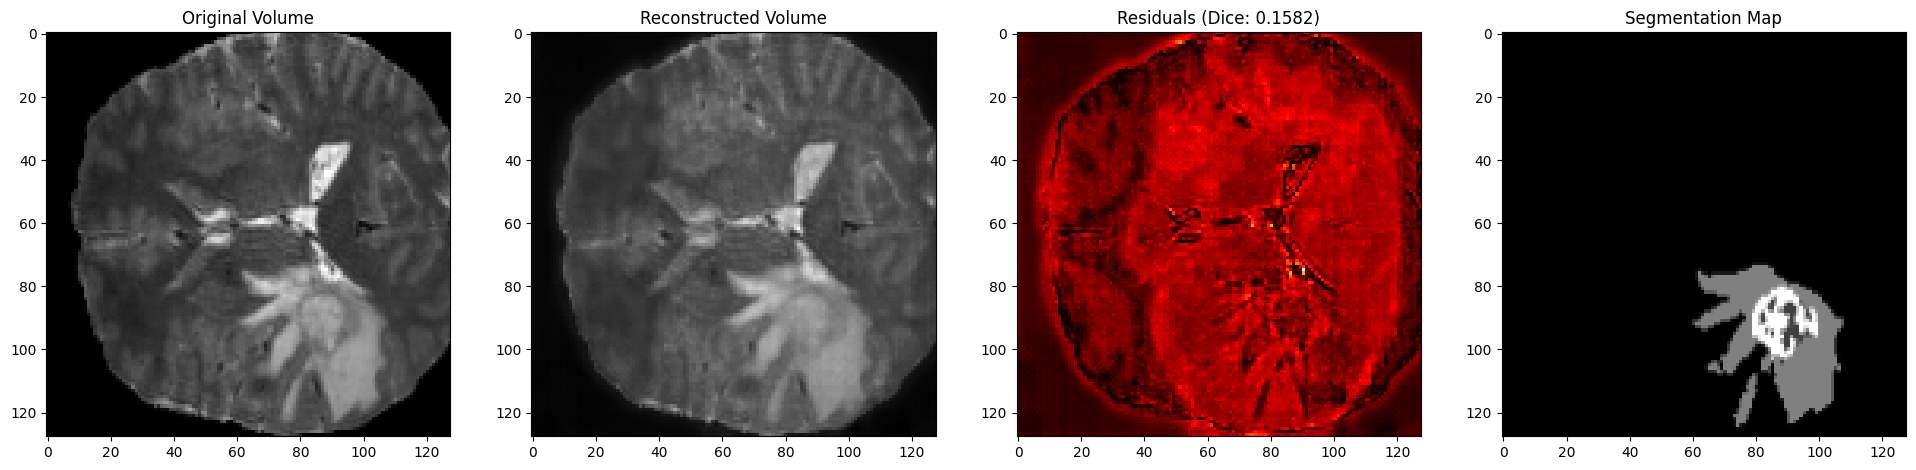

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_083: Dice Score: 0.1582


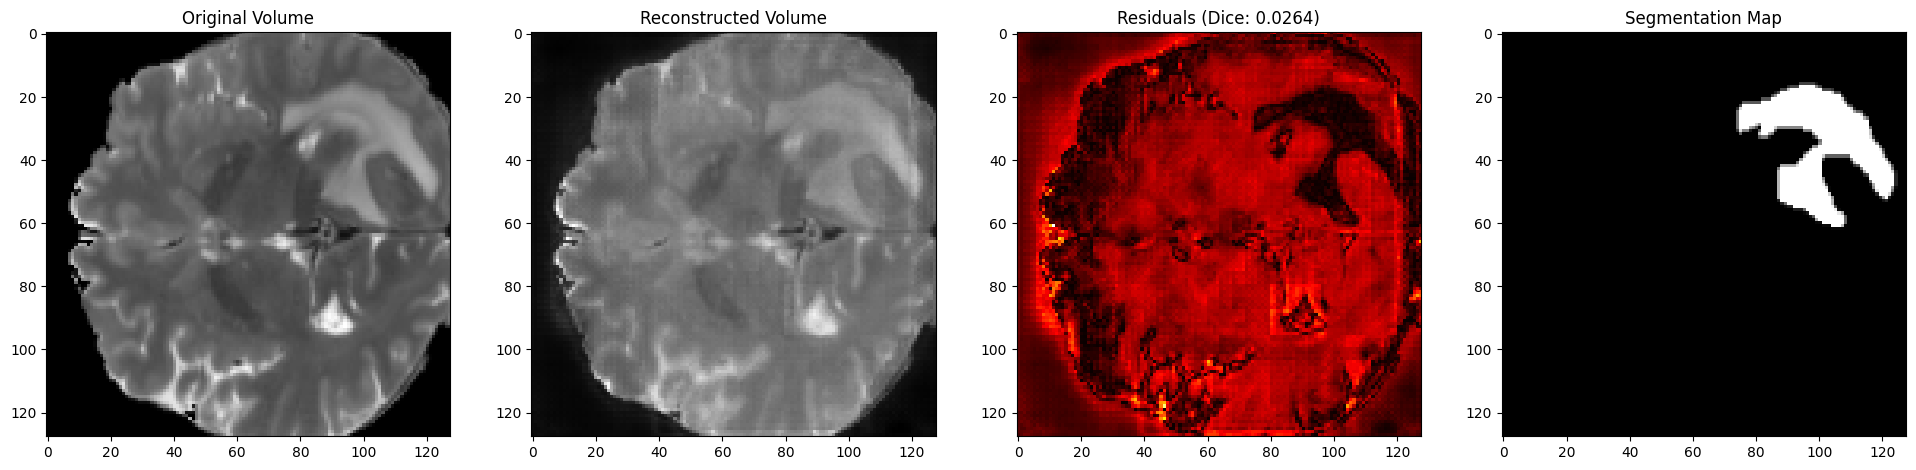

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_337: Dice Score: 0.0264


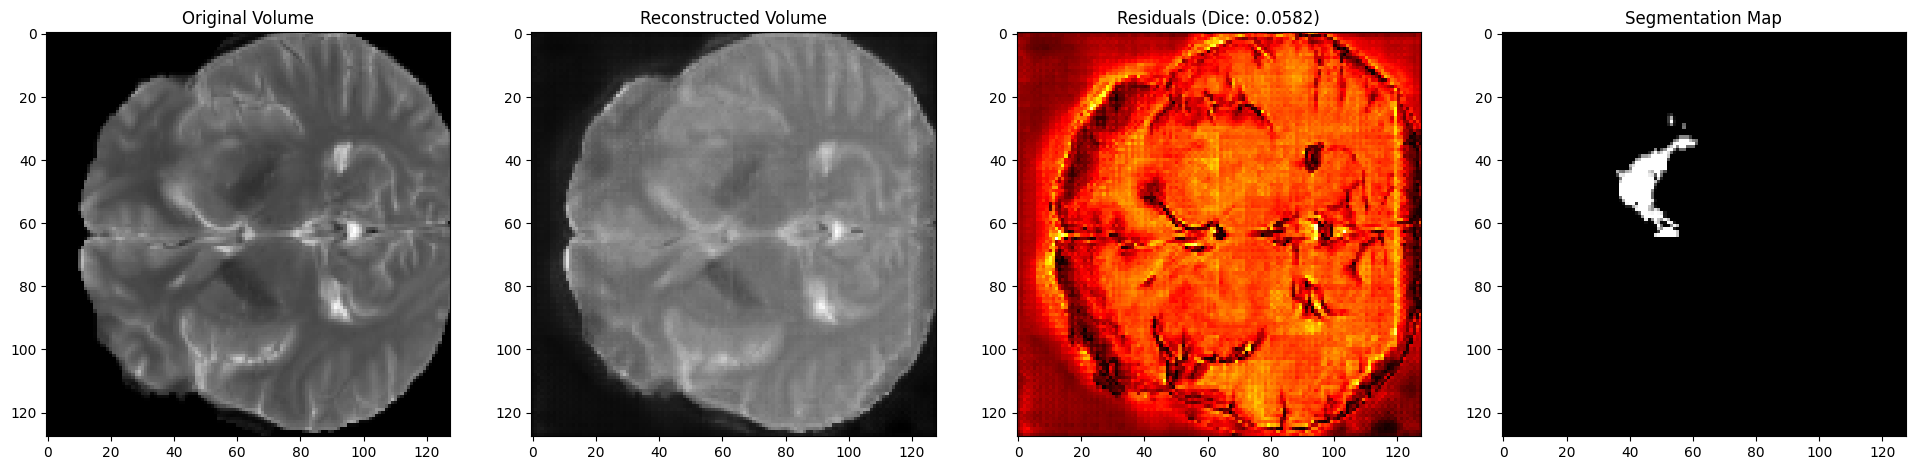

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_161: Dice Score: 0.0582


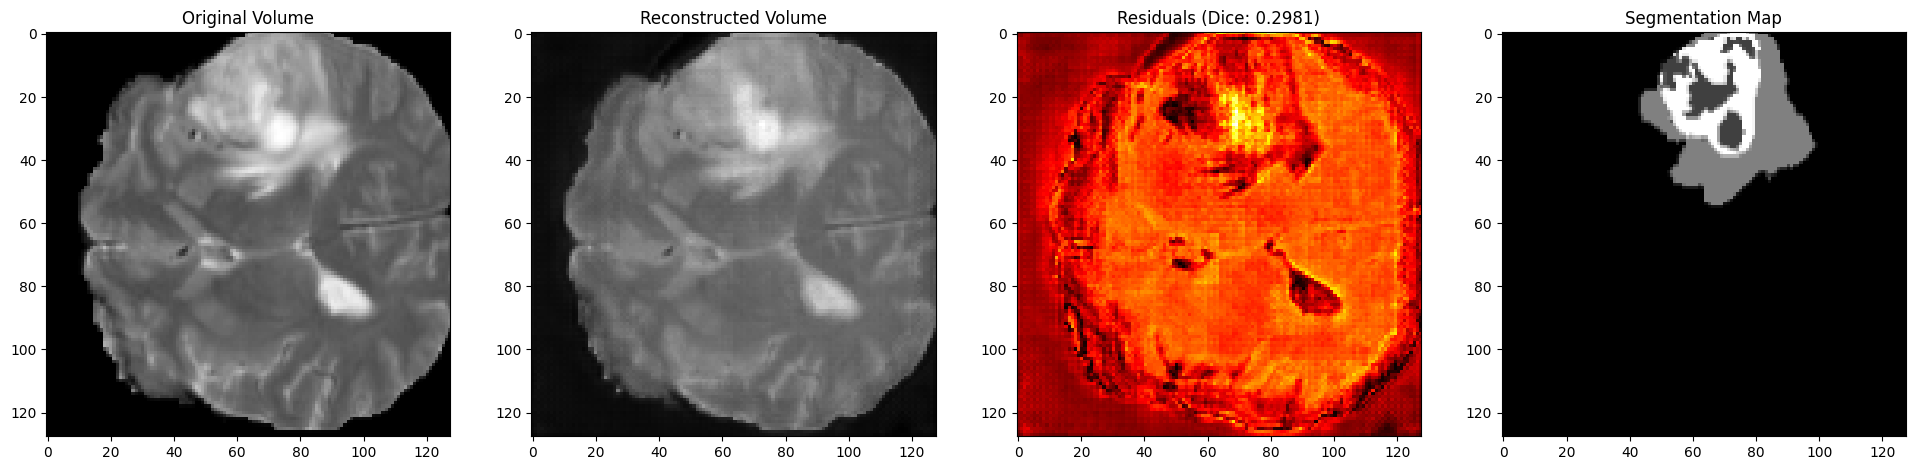

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_198: Dice Score: 0.2981


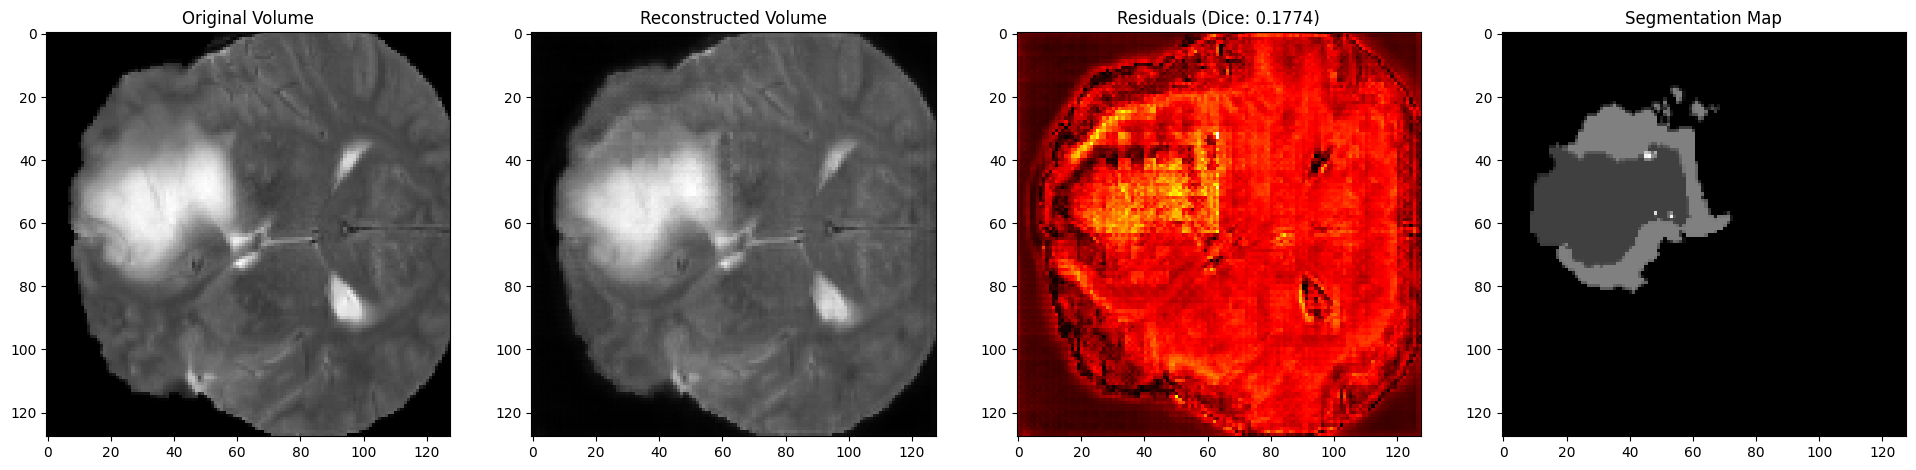

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_284: Dice Score: 0.1774


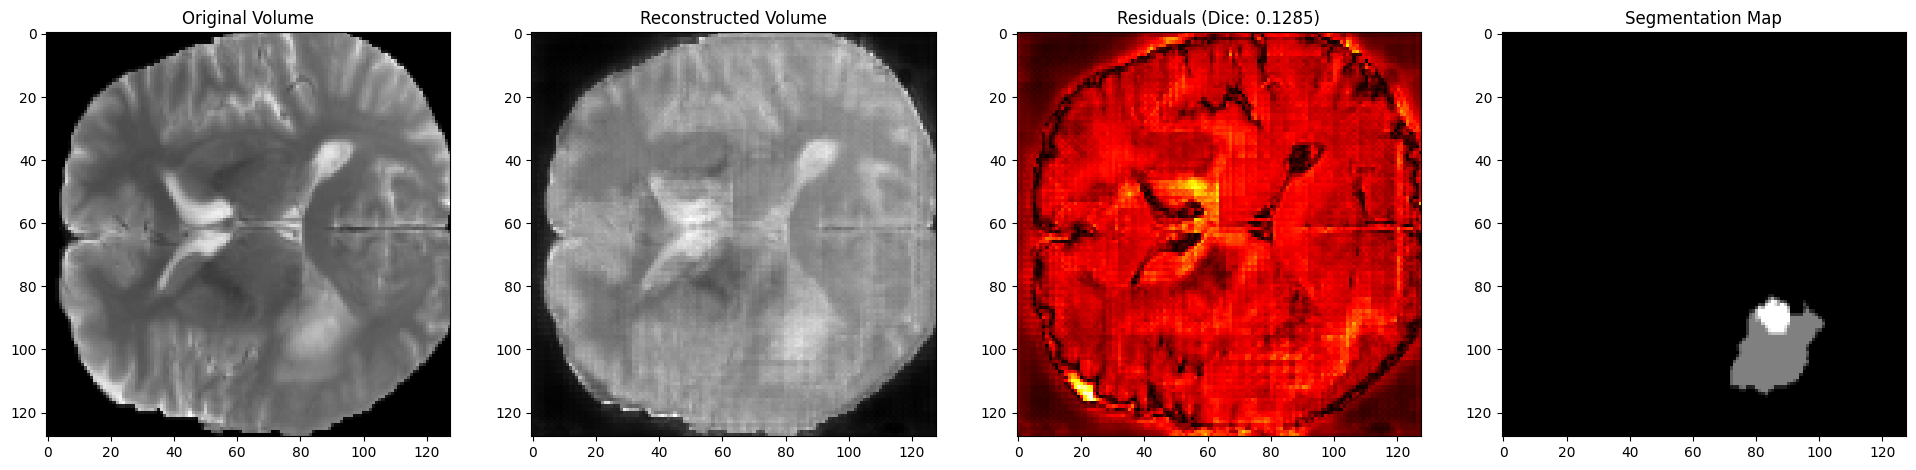

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_169: Dice Score: 0.1285


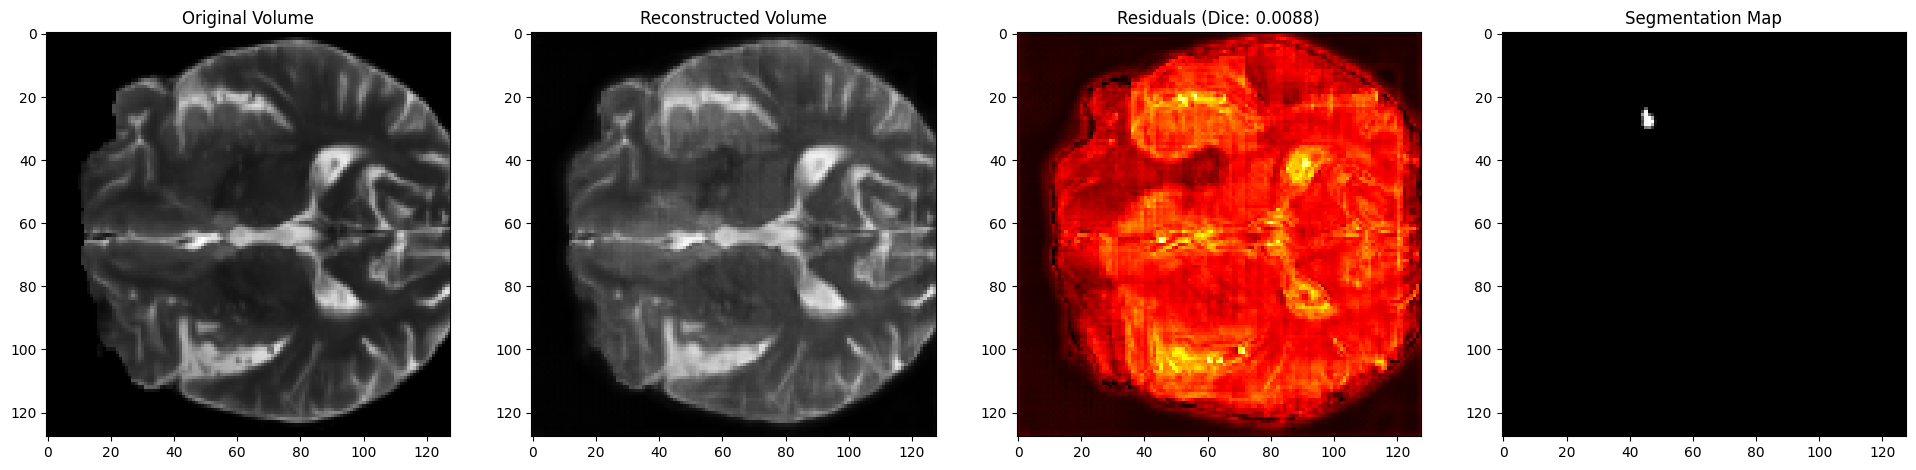

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_157: Dice Score: 0.0088


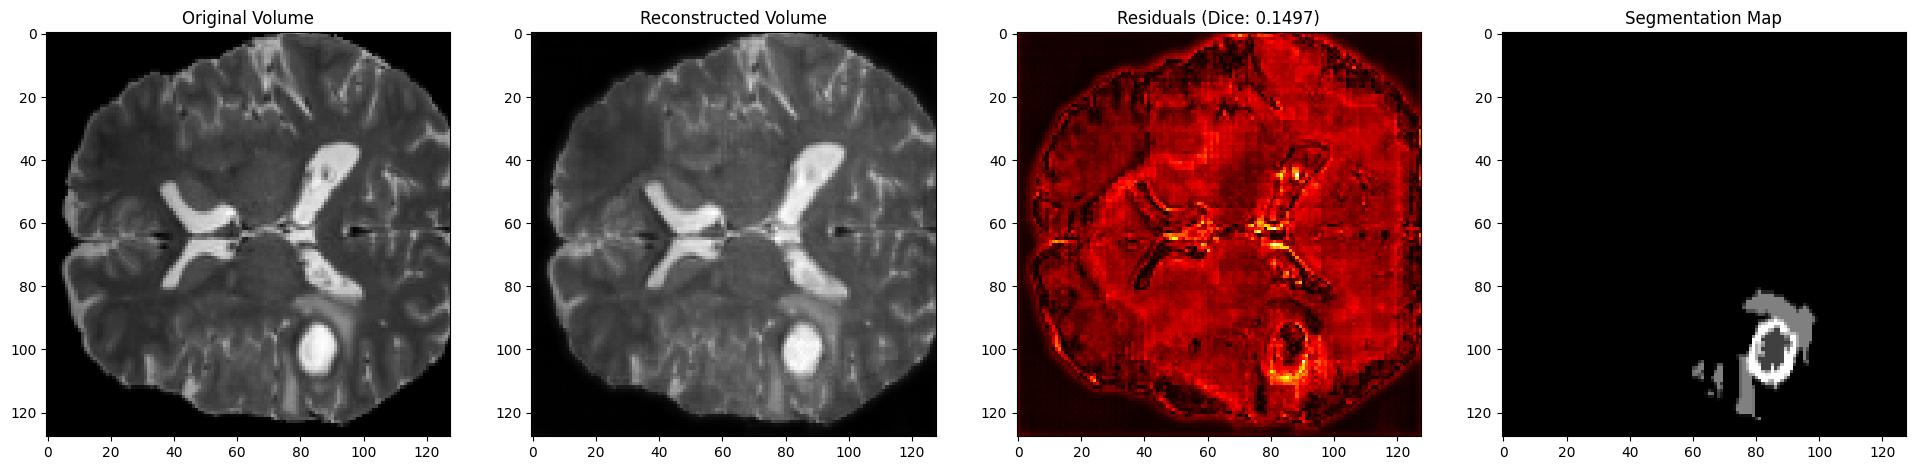

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_073: Dice Score: 0.1497


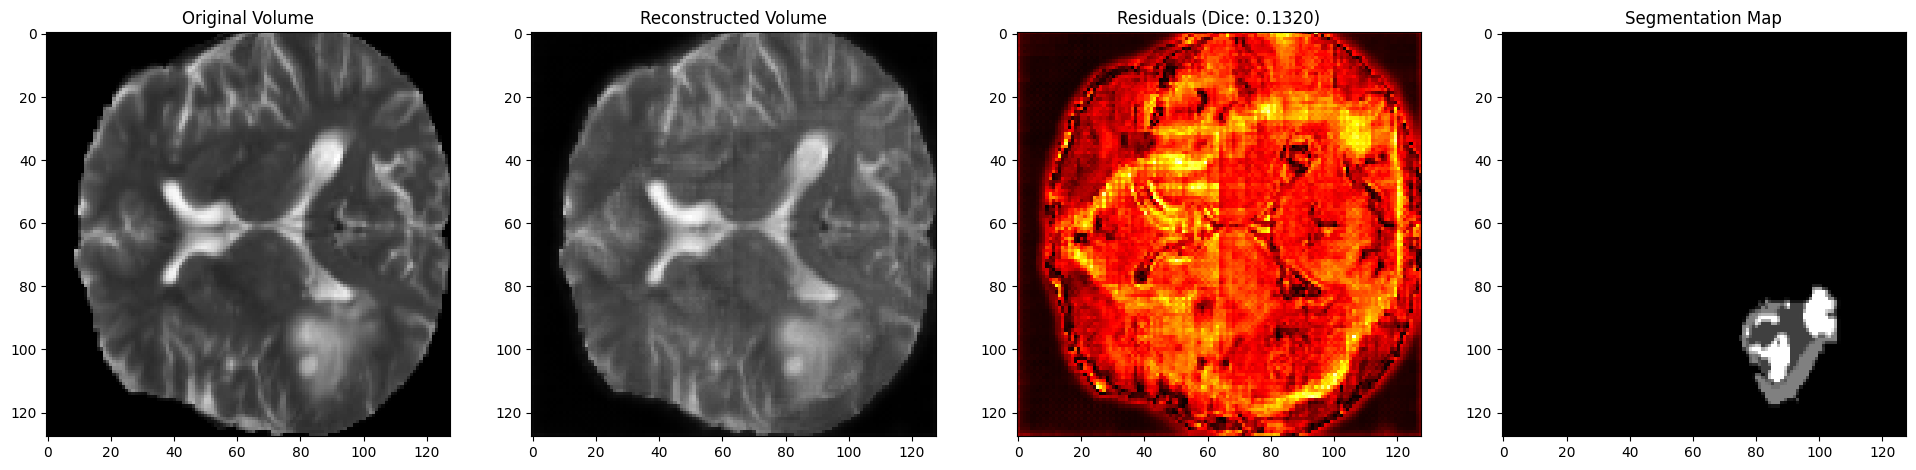

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_253: Dice Score: 0.1320


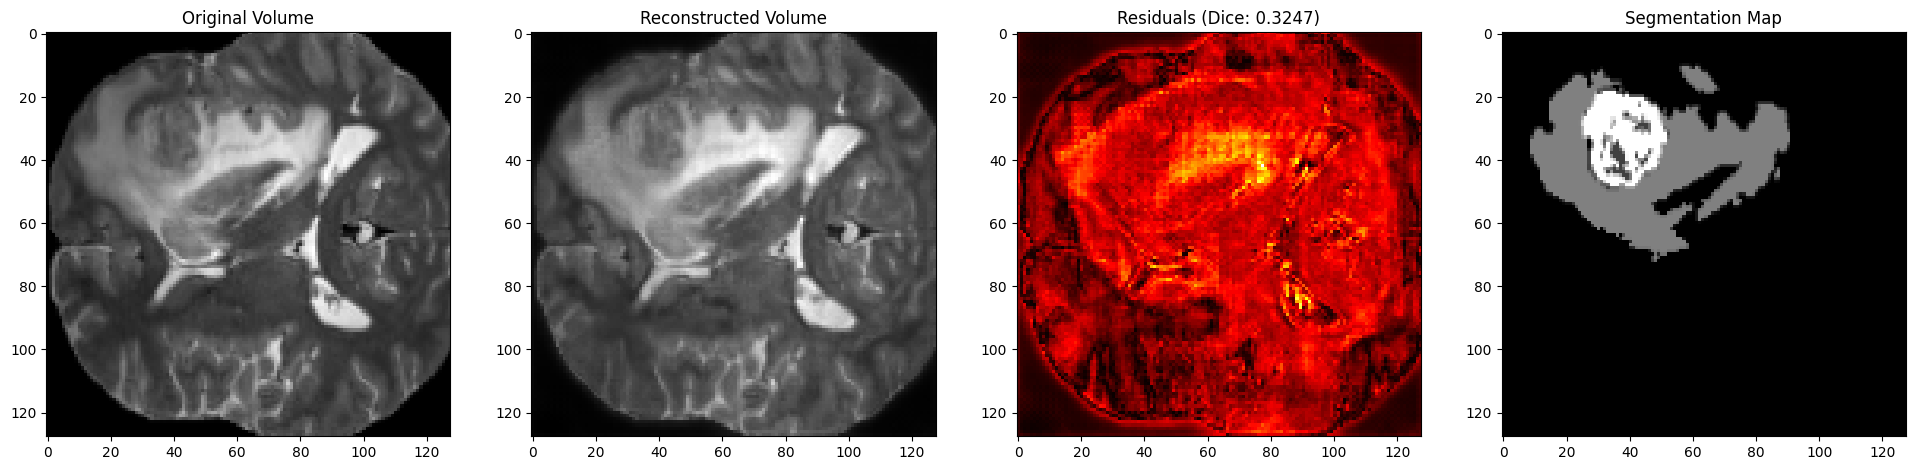

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_026: Dice Score: 0.3247
Avg Dice Score: 0.3247
Avg iou Score: 0.1939


In [12]:
data_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# Loop through each checkpoint
for path in checkpoint_paths:
    # Load model checkpoint
    print(path)
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)
    model.eval()

    # Loop through all subject subdirectories
    subjects = [os.path.join(data_dir, subj) for subj in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subj))]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    subject_count = 10
    curr_count = 0


    for subject_dir in subjects:
        if curr_count < subject_count:
            t2_path = os.path.join(subject_dir, [f for f in os.listdir(subject_dir) if '_t2.nii' in f][0])
            seg_path = t2_path.replace('_t2.nii', '_seg.nii')

            # Load and normalize volumes
            t2_vol = nib.load(t2_path).get_fdata()
            seg_vol = nib.load(seg_path).get_fdata()
            t2_norm = (t2_vol - np.min(t2_vol)) / (np.max(t2_vol) - np.min(t2_vol))

            # Preprocess volumes
            transpose_vol = np.transpose(t2_norm, (2, 0, 1))  
            cropped_vol = crop(transpose_vol)
            resized_vol = resize_volume(cropped_vol)
            transpose_seg_vol = np.transpose(seg_vol, (2, 0, 1))
            cropped_seg_vol = crop(transpose_seg_vol)
            resized_seg_vol = resize_volume(cropped_seg_vol)

            # Split into slices
            slices_vol = get_slices(resized_vol)
            slices_seg = get_slices(resized_seg_vol)
            
            dice_scores = []
            iou_scores = []

            with torch.no_grad():
                tensor_vol_slice = slices_vol[4].to(device)
                output = model(tensor_vol_slice)
                
                output = (output - output.min()) / (output.max() - output.min())
                
                # Calculate residuals with MSE
                residuals = torch.abs(tensor_vol_slice - output)

                # Apply threshold and calculate Dice score
                threshold = 0.1
                residuals_binary = (residuals > threshold).float()
                tensor_seg_slice = slices_seg[4].to(device)
#                 tensor_seg_slice = (tensor_seg_slice - tensor_seg_slice.min()) / (tensor_seg_slice.max() - tensor_seg_slice.min())
                dice = dice_score(tensor_seg_slice, residuals_binary)

                # Calculate IoU
                iou = iou_score(tensor_seg_slice, residuals_binary)
            
                dice_scores.append(dice)
                iou_scores.append(iou)

            # Plot example slices
            depth = 8  # Slice depth to visualize
            fig, ax = plt.subplots(1, 4, figsize=(24, 6))

            # Plot the original MRI volume slice
            ax[0].imshow(tensor_vol_slice[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
            ax[0].set_title('Original Volume')

            # Plot the reconstructed volume slice
            ax[1].imshow(output[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
            ax[1].set_title('Reconstructed Volume')

            # Plot the residual map slice
            ax[2].imshow(residuals[0, 0, depth, :, :].cpu().numpy(), cmap='hot')
            ax[2].set_title(f'Residuals (Dice: {dice:.4f})')

            # Plot the corresponding segmentation map slice
            ax[3].imshow(tensor_seg_slice[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
            ax[3].set_title('Segmentation Map')

            plt.show()
            print(f"Processed {subject_dir}: Dice Score: {dice:.4f}")
        
        curr_count += 1
        
    dice = np.mean(dice_scores)
    iou = np.mean(iou_scores)
    print(f"Avg Dice Score: {dice:.4f}")
    print(f"Avg iou Score: {iou:.4f}")